In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

import string
alphabet=list(string.ascii_lowercase)

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.
cobalt_n_2_o2 = 118./16.
cobalt_n_2_n_denit = 472.0/(5.0*16.0)

In [2]:
cases={}
cases['ctrl']={}
cases['tunOnly']={}
cases['hpOnly']={}
cases['tun_hp']={}

for i in cases:
    cases[i]['machine_target']='gfdl.ncrc4-intel19-prod'
    if i == 'ctrl':
        cases[i]['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'
    else:
        cases[i]['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2'
            
cases['ctrl']['name']='OM4p5_CORE2_IAF_gzCOBALT-013022_cy5'
cases['tunOnly']['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_cy5'
cases['hpOnly']['name']='OM4p5_CORE2_IAF_gzCOBALT-hp_cy5'
cases['tun_hp']['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5'

print(cases)

{'ctrl': {'machine_target': 'gfdl.ncrc4-intel19-prod', 'path_root': '/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT', 'name': 'OM4p5_CORE2_IAF_gzCOBALT-013022_cy5'}, 'tunOnly': {'machine_target': 'gfdl.ncrc4-intel19-prod', 'path_root': '/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2', 'name': 'OM4p5_CORE2_IAF_gzCOBALT-tun_cy5'}, 'hpOnly': {'machine_target': 'gfdl.ncrc4-intel19-prod', 'path_root': '/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2', 'name': 'OM4p5_CORE2_IAF_gzCOBALT-hp_cy5'}, 'tun_hp': {'machine_target': 'gfdl.ncrc4-intel19-prod', 'path_root': '/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2', 'name': 'OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5'}}


In [3]:
#grid_file=os.path.join(cases['ctrl']['path_root'], cases['ctrl']['name'], cases['ctrl']['machine_target'], 'pp')+'/ocean_annual/ocean_annual.static.nc'
#grid=xr.open_dataset(grid_file)
grid = xr.open_dataset('/work/jyl/tmp/ocean_static.nc')

In [4]:
import pandas as pd
pd.DataFrame.from_dict(cases).T

,machine_target,path_root,name
ctrl,gfdl.ncrc4-intel19-prod,/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT,OM4p5_CORE2_IAF_gzCOBALT-013022_cy5
tunOnly,gfdl.ncrc4-intel19-prod,/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2,OM4p5_CORE2_IAF_gzCOBALT-tun_cy5
hpOnly,gfdl.ncrc4-intel19-prod,/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2,OM4p5_CORE2_IAF_gzCOBALT-hp_cy5
tun_hp,gfdl.ncrc4-intel19-prod,/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2,OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5


# Read in Files
Use epc100 from ocean_cobalt_omip_2d

Use expc from ocean_cobalt_omip_rates_year_z, and select for z_l=1000. not exactly the flux at 1000 m but we don't have anything else

Then use fndet_fast_btm and fndet_btm from ocean_cobalt_btm (note it is in N units)

In [5]:
diagTypes_mon = ['ocean_cobalt_btm'] 
pp_dates='1988-2007'

just read everything in because python doesn't store it in memory until you actually need to use it

In [7]:
case='ctrl'

files_mon=[glob('/work/Jessica.Luo/tmp/'+cases[case]['name'] + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes_mon]
files_mon=sorted([f for fi in files_mon for f in fi]) # nested list comprehension

dc_mon = xr.open_mfdataset(files_mon, combine='by_coords')


In [8]:
case='tunOnly'

files_mon=[glob('/work/Jessica.Luo/tmp/'+cases[case]['name'] + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes_mon]
files_mon=sorted([f for fi in files_mon for f in fi]) # nested list comprehension

d1_mon = xr.open_mfdataset(files_mon, combine='by_coords')


In [9]:
case='hpOnly'

files_mon=[glob('/work/Jessica.Luo/tmp/'+cases[case]['name'] + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes_mon]
files_mon=sorted([f for fi in files_mon for f in fi]) # nested list comprehension

d2_mon = xr.open_mfdataset(files_mon, combine='by_coords')


In [10]:
case='tun_hp'

files_mon=[glob('/work/Jessica.Luo/tmp/'+cases[case]['name'] + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes_mon]
files_mon=sorted([f for fi in files_mon for f in fi]) # nested list comprehension

d3_mon = xr.open_mfdataset(files_mon, combine='by_coords')


In [11]:
days_in_month = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31], coords={'time':dc_mon.time}, dims='time')

In [12]:
days_in_month_wgts=days_in_month / days_in_month.mean()
days_in_month_wgts

<xarray.DataArray (time: 12)>
array([1.01917808, 0.92054795, 1.01917808, 0.98630137, 1.01917808,
       0.98630137, 1.01917808, 1.01917808, 0.98630137, 1.01917808,
       0.98630137, 1.01917808])
Coordinates:
  * time     (time) object 1999-07-18 00:00:00 ... 2000-06-17 00:00:00

## Extract variables

In [13]:
dc_mon.fnoxic_sed.attrs # units of mol N n-2 s-1

{'long_name': 'Sediment oxic Ndet remineralization flux',
 'units': 'mol m-2 s-1',
 'cell_measures': 'area: areacello',
 'cell_methods': 'area:mean yh:mean xh:mean time: mean within months time: mean over years',
 'time_avg_info': 'average_T1,average_T2,average_DT'}

In [14]:
TOC_ctrl = (dc_mon.fnoxic_sed * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day # convert to mmol O2 m-2 d-1
TOC_tunOnly = (d1_mon.fnoxic_sed * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day
TOC_hpOnly = (d2_mon.fnoxic_sed * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day
TOC_tun_hp = (d3_mon.fnoxic_sed * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day

In [15]:
val_TOC_ctrl = (TOC_ctrl * grid.areacello).sum(dim=['xh','yh']).values * 365 * 1e-3 # convert to mol O2 y-1
val_TOC_tun = (TOC_tunOnly * grid.areacello).sum(dim=['xh','yh']).values * 365 * 1e-3
val_TOC_hp = (TOC_hpOnly * grid.areacello).sum(dim=['xh','yh']).values * 365 * 1e-3
val_TOC_tun_hp = (TOC_tun_hp * grid.areacello).sum(dim=['xh','yh']).values * 365 * 1e-3

In [16]:
print('Bottom O2 consumption')
print('Ctrl: '+ str(np.round(val_TOC_ctrl/1e12,2)) + ' Tmol O2/yr')
print('Tun only: '+ str(np.round(val_TOC_tun/1e12,2)) + ' Tmol O2/yr; % diff: ' + str(np.round((val_TOC_tun - val_TOC_ctrl)/val_TOC_ctrl * 100,1)) + '%')
print('HP only: '+ str(np.round(val_TOC_hp/1e12,2)) + ' Tmol O2/yr; % diff: ' + str(np.round((val_TOC_hp - val_TOC_ctrl)/val_TOC_ctrl * 100,1)) + '%')
print('Tun & HP: '+ str(np.round(val_TOC_tun_hp/1e12,2)) + ' Tmol O2/yr; % diff: ' + str(np.round((val_TOC_tun_hp - val_TOC_ctrl)/val_TOC_ctrl * 100,1)) + '%')

Bottom O2 consumption
Ctrl: 99.04 Tmol O2/yr
Tun only: 106.69 Tmol O2/yr; % diff: 7.7%
HP only: 107.36 Tmol O2/yr; % diff: 8.4%
Tun & HP: 113.08 Tmol O2/yr; % diff: 14.2%


## Convert from export flux to bottom oxygen consumption

In [20]:
dc_mon.fndet_btm.attrs

{'long_name': 'ndet sinking flux to bottom',
 'units': 'mol m-2 s-1',
 'cell_measures': 'area: areacello',
 'cell_methods': 'area:mean yh:mean xh:mean time: mean within months time: mean over years',
 'time_avg_info': 'average_T1,average_T2,average_DT'}

In [21]:
btm_poc_ctrl = ((dc_mon.fndet_btm * grid.areacello).sum(dim=['xh','yh']) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_c * 12 * seconds_per_year
btm_poc_tunOnly = (((d1_mon.fndet_btm + d1_mon.fndet_fast_btm) * grid.areacello).sum(dim=['xh','yh']) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_c * 12 * seconds_per_year
btm_poc_hpOnly = (((d2_mon.fndet_btm + d2_mon.fndet_fast_btm) * grid.areacello).sum(dim=['xh','yh']) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_c * 12 * seconds_per_year
btm_poc_tun_hp = (((d3_mon.fndet_btm + d3_mon.fndet_fast_btm) * grid.areacello).sum(dim=['xh','yh']) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_c * 12 * seconds_per_year

In [22]:
print(btm_poc_ctrl.values/1e15)
print(btm_poc_tunOnly.values/1e15)
print(btm_poc_hpOnly.values/1e15)
print(btm_poc_tun_hp.values/1e15)

1.2619544680224
1.332018122094
1.34085143774565
1.4014869642729


In [23]:
((btm_poc_tun_hp-btm_poc_ctrl)/btm_poc_ctrl).values *100

11.0568566288418

In [24]:
TOC_supplyOnly_ctrl = (dc_mon.fndet_btm * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day # convert to mmol O2 m-2 d-1
TOC_supplyOnly_tunOnly = ((d1_mon.fndet_btm + d1_mon.fndet_fast_btm) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day
TOC_supplyOnly_hpOnly = ((d2_mon.fndet_btm + d2_mon.fndet_fast_btm) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day
TOC_supplyOnly_tun_hp = ((d3_mon.fndet_btm  + d3_mon.fndet_fast_btm) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day

In [25]:
dc_mon.fndet_burial.attrs

{'long_name': 'ndet burial flux',
 'units': 'mol m-2 s-1',
 'cell_measures': 'area: areacello',
 'cell_methods': 'area:mean yh:mean xh:mean time: mean within months time: mean over years',
 'time_avg_info': 'average_T1,average_T2,average_DT'}

In [26]:
TOC_supplyMinusBurial_ctrl = ((dc_mon.fndet_btm - dc_mon.fndet_burial) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day # convert to mmol O2 m-2 d-1
TOC_supplyMinusBurial_tunOnly = ((d1_mon.fndet_btm + d1_mon.fndet_fast_btm - d1_mon.fndet_burial) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day
TOC_supplyMinusBurial_hpOnly = ((d2_mon.fndet_btm + d2_mon.fndet_fast_btm - d2_mon.fndet_burial) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day
TOC_supplyMinusBurial_tun_hp = ((d3_mon.fndet_btm + d3_mon.fndet_fast_btm - d3_mon.fndet_burial) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day

### Add sediment denitrification following Middelburg et al. 1996
$log_{10}(Den) = -0.9543 + 0.7662 * log_{10}(F_c) - 0.2350 * log_{10}(F_c)^2$

$F_c$ in units of mmoles C m-2 day-1

call g_tracer_add_param('n_2_n_denit', cobalt%n_2_n_denit, 472.0/(5.0*16.0))             ! mol N NO3 mol N org-1

In [27]:
# convert PON to bottom in from mol N m-2 s-1 to micromol C cm-2 day-1
fcdet_btm_ctrl = dc_mon.fndet_btm * cobalt_n_2_c * 1e6 * 1e-4 * seconds_per_day
fcdet_btm_tunOnly = (d1_mon.fndet_btm + d1_mon.fndet_fast_btm) * cobalt_n_2_c * 1e6 * 1e-4 * seconds_per_day
fcdet_btm_hpOnly = (d2_mon.fndet_btm + d2_mon.fndet_fast_btm) * cobalt_n_2_c * 1e6 * 1e-4 * seconds_per_day
fcdet_btm_tun_hp = (d3_mon.fndet_btm + d3_mon.fndet_fast_btm) * cobalt_n_2_c * 1e6 * 1e-4 * seconds_per_day

In [28]:
# calculate benthic denitrification - in units of microlmol C cm-2 d-1
benthicDenitrif_ctrl = 10**(-0.9543 + 0.7662 * np.log10(fcdet_btm_ctrl) - 0.2350 * np.log10(fcdet_btm_ctrl)**2)
benthicDenitrif_tunOnly = 10**(-0.9543 + 0.7662 * np.log10(fcdet_btm_tunOnly) - 0.2350 * np.log10(fcdet_btm_tunOnly)**2)
benthicDenitrif_hpOnly = 10**(-0.9543 + 0.7662 * np.log10(fcdet_btm_hpOnly) - 0.2350 * np.log10(fcdet_btm_hpOnly)**2)
benthicDenitrif_tun_hp = 10**(-0.9543 + 0.7662 * np.log10(fcdet_btm_tun_hp) - 0.2350 * np.log10(fcdet_btm_tun_hp)**2)

In [29]:
# convert back from microlmol C cm-2 d-1 to mol N m-2 s-1
benthicDenitrif_ctrl = benthicDenitrif_ctrl * 1e4 * 1e-6 / cobalt_n_2_c / seconds_per_day / cobalt_n_2_n_denit
benthicDenitrif_tunOnly = benthicDenitrif_tunOnly * 1e4 * 1e-6 / cobalt_n_2_c / seconds_per_day / cobalt_n_2_n_denit
benthicDenitrif_hpOnly = benthicDenitrif_hpOnly * 1e4 * 1e-6 / cobalt_n_2_c / seconds_per_day / cobalt_n_2_n_denit
benthicDenitrif_tun_hp = benthicDenitrif_tun_hp * 1e4 * 1e-6 / cobalt_n_2_c / seconds_per_day / cobalt_n_2_n_denit

In [30]:
TOC_supplyMinusBurialAndDenitrif_ctrl = ((dc_mon.fndet_btm - dc_mon.fndet_burial - benthicDenitrif_ctrl) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day # convert to mmol O2 m-2 d-1
TOC_supplyMinusBurialAndDenitrif_tunOnly = ((d1_mon.fndet_btm + d1_mon.fndet_fast_btm - d1_mon.fndet_burial - benthicDenitrif_tunOnly) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day
TOC_supplyMinusBurialAndDenitrif_hpOnly = ((d2_mon.fndet_btm + d2_mon.fndet_fast_btm - d2_mon.fndet_burial - benthicDenitrif_hpOnly) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day
TOC_supplyMinusBurialAndDenitrif_tun_hp = ((d3_mon.fndet_btm + d3_mon.fndet_fast_btm - d3_mon.fndet_burial - benthicDenitrif_tun_hp) * days_in_month_wgts).mean(dim='time') * cobalt_n_2_o2 * 1e3 * seconds_per_day

In [31]:
btm_resp_ctrl = (TOC_supplyMinusBurialAndDenitrif_ctrl * grid.areacello).sum(dim=['xh','yh']) * 1e-3 * 365
btm_resp_tunOnly = (TOC_supplyMinusBurialAndDenitrif_tunOnly * grid.areacello).sum(dim=['xh','yh']) * 1e-3 * 365
btm_resp_hpOnly = (TOC_supplyMinusBurialAndDenitrif_hpOnly * grid.areacello).sum(dim=['xh','yh']) * 1e-3 * 365
btm_resp_tun_hp = (TOC_supplyMinusBurialAndDenitrif_tun_hp * grid.areacello).sum(dim=['xh','yh']) * 1e-3 * 365

pctinc_tunOnly = (btm_resp_tunOnly - btm_resp_ctrl) / btm_resp_ctrl * 100
pctinc_hpOnly = (btm_resp_hpOnly - btm_resp_ctrl) / btm_resp_ctrl * 100
pctinc_tun_hp = (btm_resp_tun_hp - btm_resp_ctrl) / btm_resp_ctrl * 100

print('Total Oxygen Consumption')
print('Ctrl: ' + str(np.round(btm_resp_ctrl.values/1e12)) + ' Tmol O2 y-1')
print('Tun Only: ' + str(np.round(btm_resp_tunOnly.values/1e12)) + ' Tmol O2 y-1, % increase: ' + str(np.round(pctinc_tunOnly.values,1)))
print('HP Only: ' + str(np.round(btm_resp_hpOnly.values/1e12)) + ' Tmol O2 y-1, % increase: ' + str(np.round(pctinc_hpOnly.values,1)))
print('Combined: ' + str(np.round(btm_resp_tun_hp.values/1e12)) + ' Tmol O2 y-1, % increase: ' + str(np.round(pctinc_tun_hp.values,1)))

Total Oxygen Consumption
Ctrl: 103.0 Tmol O2 y-1
Tun Only: 110.0 Tmol O2 y-1, % increase: 6.5
HP Only: 111.0 Tmol O2 y-1, % increase: 7.1
Combined: 116.0 Tmol O2 y-1, % increase: 12.4


# Observations

In [32]:
#obs_file = '/work/jyl/validation_data/Jorgensen_Data/Jorgensen_etal_2022_TOU_x0.1.nc'
obs_file = '/work/jyl/validation_data/Jorgensen_Data/Jorgensen_etal_2022_TOU_fromSulpis.nc'

obs = xr.open_dataset(obs_file)

if obs_file=='/work/jyl/validation_data/Jorgensen_Data/Jorgensen_etal_2022_TOU_x0.1.nc':
    obs = obs.rename({'x':'lon', 'y':'lat'})
    
if obs_file=='/work/jyl/validation_data/Jorgensen_Data/Jorgensen_etal_2022_TOU_fromSulpis.nc':
    obs['TOU'] = obs.TOU/365*1e3 # convert from mol m-2 y-1 to mmol m-2 d-1
    obs['TOU'].attrs['units']='mmol m-2 d-1'

In [33]:
obs.TOU
#obs_TOU = obs.TOU.shift(lon=180)

<xarray.DataArray 'TOU' (lat: 1080, lon: 2160)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.92 -89.76 -89.59 -89.42 ... 89.58 89.74 89.91
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.7 179.9
Attributes:
    units:    mmol m-2 d-1

## Compute Weighted TOU
Example from http://research.jisao.washington.edu/data_sets/nco/#example12

In [34]:
obs['coslat'] = np.cos(obs.lat*(np.pi/180.))
#obs['oceanmask']=obs.where(obs.TOU)

In [35]:
obs['TOU_weighted'] = (obs.TOU * obs.coslat) / obs.where(~np.isnan(obs.TOU)).coslat.mean()
obs.TOU_weighted.mean()

<xarray.DataArray 'TOU_weighted' ()>
array(1.73755242)

In [36]:
seafloor_TOU_sum = obs.TOU_weighted.mean().values * 3.61e+14 # oceans seabed area, from Costello et al. 2010
seafloor_TOU_sum = seafloor_TOU_sum *1e-3 * 365 # values in mol O2 m-2 y-1
print('Obs seafloor TOU: ' + str(np.format_float_scientific(seafloor_TOU_sum,2)) + ' mol O2 m-2 y-1')

Obs seafloor TOU: 2.29e+14 mol O2 m-2 y-1


# Plot - benthic oxygen consumption from Model

In [44]:
vmin=-0.7
vmax=2
ticks=np.linspace(vmin,vmax,6)
ticks10=[np.round(10**x,2) for x in ticks]
ticks10

cmap='RdYlBu_r'
cmap_na = plt.cm.get_cmap('RdYlBu_r').copy()
cmap_na.set_bad('#DDDDDD',1.)

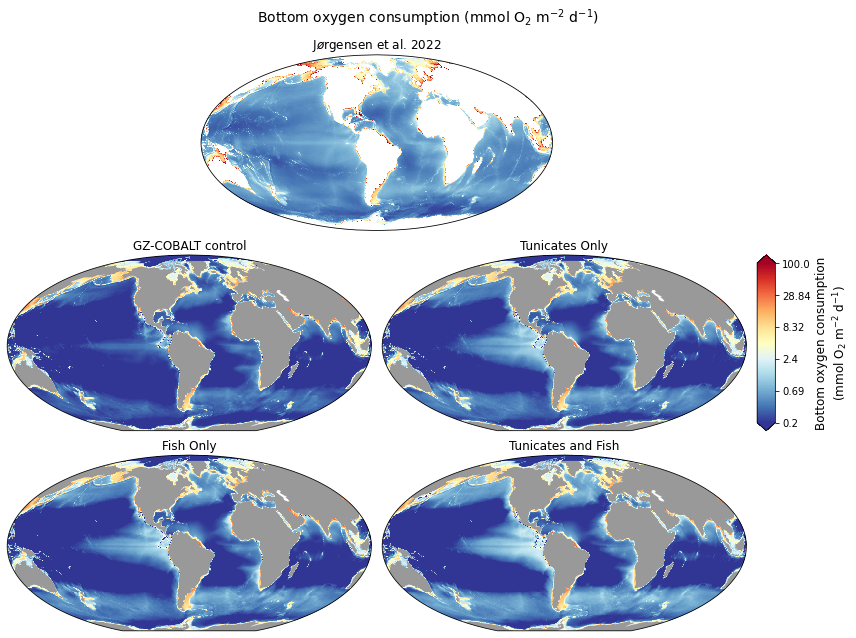

In [49]:
fig=plt.figure(figsize=(12,9))
gs=gridspec.GridSpec(3,3, width_ratios=[1,1,0.05])

ax={};cs={}

fig.suptitle('Bottom oxygen consumption (mmol O$_2$ m$^{-2}$ d$^{-1}$)', fontsize=14)


i=0
ax[i]=plt.subplot(gs[0,0:-1],projection=ccrs.Mollweide(central_longitude=300.0))
obs_field=np.log10(obs.TOU.values)
cs[i]=ax[i].pcolormesh(obs.lon.values, obs.lat.values, obs_field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('J${\o}$rgensen et al. 2022', fontsize=12)

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_ctrl)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
# cbar=plt.colorbar(cs, extend='both', ticks=ticks, shrink=0.75)
# cbar.ax.set_yticklabels(ticks10)
plt.title('GZ-COBALT control', fontsize=12)


i=2
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_tunOnly)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('Tunicates Only', fontsize=12)


i=3
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_hpOnly)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
# cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
# cbar.ax.set_yticklabels(ticks10)
plt.title('Fish Only', fontsize=12)


i=4
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_tun_hp)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('Tunicates and Fish', fontsize=12)


cbar = plt.colorbar(cs[i], extend='both', ticks=ticks, cax=plt.subplot(gs[1, 2]))
cbar.ax.set_yticklabels(ticks10)
cbar.set_label('Bottom oxygen consumption\n(mmol O$_2$ m$^{-2}$ d$^{-1}$)', fontsize=12)

plt.tight_layout()
plt.savefig('plots/Combined_Bottom_Oxygen_Consumption_from_fnoxic_sed.png', dpi=300, bbox_inches='tight')

## Subsequent plots - benthic oxygen consumption from different components of the model

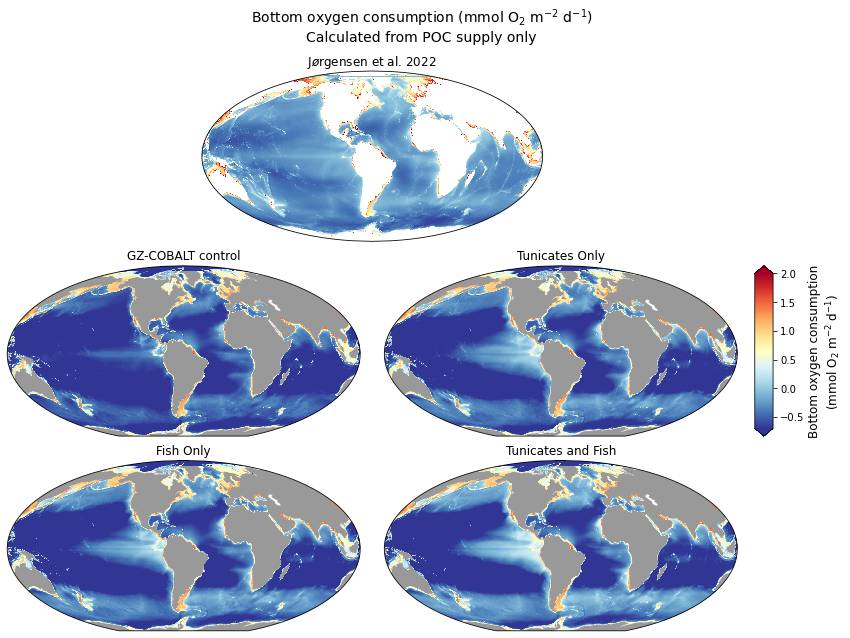

In [50]:
fig=plt.figure(figsize=(12,9))
gs=gridspec.GridSpec(3,3, width_ratios=[1,1,0.05])

ax={};cs={}

fig.suptitle('Bottom oxygen consumption (mmol O$_2$ m$^{-2}$ d$^{-1}$)\nCalculated from POC supply only', fontsize=14)


i=0
ax[i]=plt.subplot(gs[0,0:-1],projection=ccrs.Mollweide(central_longitude=300.0))
obs_field=np.log10(obs.TOU.values)
cs[i]=ax[i].pcolormesh(obs.lon.values, obs.lat.values, obs_field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('J${\o}$rgensen et al. 2022', fontsize=12)

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyOnly_ctrl)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
# cbar=plt.colorbar(cs, extend='both', ticks=ticks, shrink=0.75)
# cbar.ax.set_yticklabels(ticks10)
plt.title('GZ-COBALT control', fontsize=12)


i=2
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyOnly_tunOnly)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('Tunicates Only', fontsize=12)


i=3
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyOnly_hpOnly)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
# cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
# cbar.ax.set_yticklabels(ticks10)
plt.title('Fish Only', fontsize=12)


i=4
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyOnly_tun_hp)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('Tunicates and Fish', fontsize=12)


cbar = plt.colorbar(cs[i], extend='both', cax=plt.subplot(gs[1, 2]))
cbar.set_label('Bottom oxygen consumption\n(mmol O$_2$ m$^{-2}$ d$^{-1}$)', fontsize=12)

plt.tight_layout()
plt.savefig('plots/Combined_Bottom_Oxygen_Consumption_SupplyOnly.png', dpi=300, bbox_inches='tight')

In [ ]:
fig=plt.figure(figsize=(12,9))
gs=gridspec.GridSpec(3,3, width_ratios=[1,1,0.05])

ax={};cs={}

fig.suptitle('Bottom oxygen consumption (mmol O$_2$ m$^{-2}$ d$^{-1}$)\nCalculated from POC supply minus Burial', fontsize=14)


i=0
ax[i]=plt.subplot(gs[0,0:-1],projection=ccrs.Mollweide(central_longitude=300.0))
obs_field=np.log10(obs.TOU.values)
cs[i]=ax[i].pcolormesh(obs.lon.values, obs.lat.values, obs_field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('J${\o}$rgensen et al. 2022', fontsize=12)

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyMinusBurial_ctrl)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
# cbar=plt.colorbar(cs, extend='both', ticks=ticks, shrink=0.75)
# cbar.ax.set_yticklabels(ticks10)
plt.title('GZ-COBALT control', fontsize=12)


i=2
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyMinusBurial_tunOnly)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('Tunicates Only', fontsize=12)


i=3
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyMinusBurial_hpOnly)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
# cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
# cbar.ax.set_yticklabels(ticks10)
plt.title('Fish Only', fontsize=12)


i=4
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyMinusBurial_tun_hp)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('Tunicates and Fish', fontsize=12)


cbar = plt.colorbar(cs[i], extend='both', cax=plt.subplot(gs[1, 2]))
cbar.set_label('Bottom oxygen consumption\n(mmol O$_2$ m$^{-2}$ d$^{-1}$)', fontsize=12)

plt.tight_layout()
plt.savefig('plots/Combined_Bottom_Oxygen_Consumption_SupplyMinusBurial.png', dpi=300, bbox_inches='tight')

### Final plot

Bottom Oxygen Consumption Calculated from POC supply minus burial and denitrification

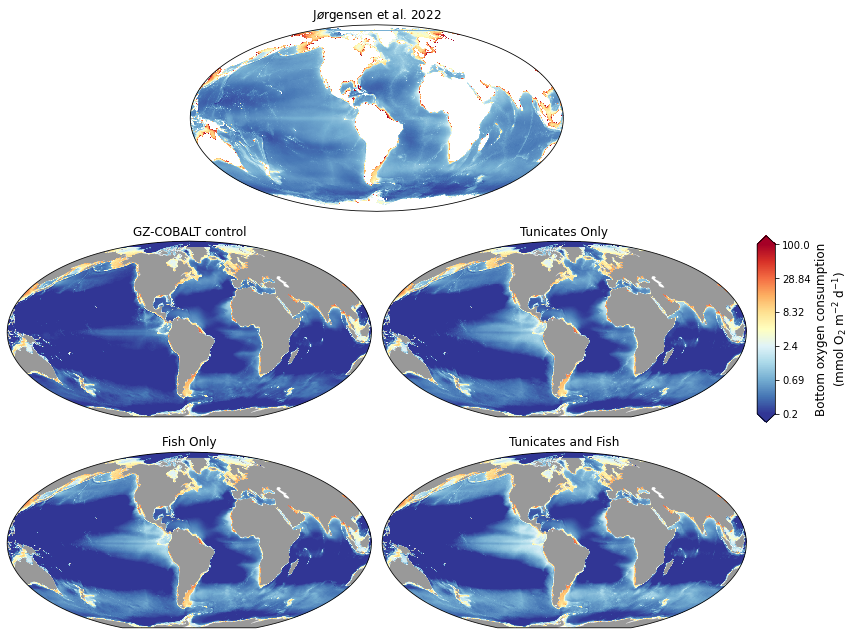

In [48]:
fig=plt.figure(figsize=(12,9))
gs=gridspec.GridSpec(3,3, width_ratios=[1,1,0.05])

ax={};cs={}

#fig.suptitle('Bottom oxygen consumption (mmol O$_2$ m$^{-2}$ d$^{-1}$)\nCalculated from POC supply minus burial and denitrification', fontsize=14)

i=0
ax[i]=plt.subplot(gs[0,0:-1],projection=ccrs.Mollweide(central_longitude=300.0))
obs_field=np.log10(obs.TOU.values)
cs[i]=ax[i].pcolormesh(obs.lon.values, obs.lat.values, obs_field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('J${\o}$rgensen et al. 2022', fontsize=12)

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyMinusBurialAndDenitrif_ctrl)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
# cbar=plt.colorbar(cs, extend='both', ticks=ticks, shrink=0.75)
# cbar.ax.set_yticklabels(ticks10)
plt.title('GZ-COBALT control', fontsize=12)


i=2
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyMinusBurialAndDenitrif_tunOnly)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('Tunicates Only', fontsize=12)


i=3
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyMinusBurialAndDenitrif_hpOnly)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
# cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
# cbar.ax.set_yticklabels(ticks10)
plt.title('Fish Only', fontsize=12)


i=4
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=np.log10(TOC_supplyMinusBurialAndDenitrif_tun_hp)
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#cbar=plt.colorbar(cs[i], extend='both', ticks=ticks, shrink=0.75)
#cbar.ax.set_yticklabels(ticks10)
plt.title('Tunicates and Fish', fontsize=12)


cbar = plt.colorbar(cs[i], extend='both', ticks=ticks, cax=plt.subplot(gs[1, 2]))
cbar.ax.set_yticklabels(ticks10)
cbar.set_label('Bottom oxygen consumption\n(mmol O$_2$ m$^{-2}$ d$^{-1}$)', fontsize=12)

plt.tight_layout()
plt.savefig('plots/Combined_Bottom_Oxygen_Consumption.png', dpi=300, bbox_inches='tight')